In [1]:
#import necessary libraries
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import sys
import os
from numpy.lib.stride_tricks import as_strided
from numpy.fft import fft, fft2, ifft2, ifft, ifftshift, fftshift
from keras.optimizers import Adam
print(os.getcwd())

/content


In [2]:
from numpy.fft import fft, fft2, ifft2, ifft, ifftshift, fftshift
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd gdrive/My\ Drive/Graduation/Modules/

/content/gdrive/My Drive/Graduation/Modules


In [5]:
from data_generator import DataGenerator
from utils import sum_of_squares
import frequency_spatial_network as fsnet

In [6]:
#adding files to the system path
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)

In [7]:
#read from files
kspace_files_train = glob.glob("/content/gdrive/My Drive/Graduation/Data/part1/*.npy")
print("Train size:",len(kspace_files_train))
kspace_files_train = np.asarray(kspace_files_train)

kspace_files_val = np.asarray(glob.glob("/content/gdrive/My Drive/Graduation/Data/val/*.npy"))
print("val size:",len(kspace_files_val))
kspace_files_val = np.asarray(kspace_files_val)

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]
print(indexes)

Train size: 4
val size: 10
[0 3 1 2]


In [8]:
#prints tpyes 
print(type(kspace_files_train))
print(kspace_files_train[0].size)
print(type(kspace_files_train[0]))
file_index = 3
slice_index = 85


<class 'numpy.ndarray'>
1
<class 'numpy.str_'>


sampleKspace type:  <class 'numpy.ndarray'>
sampleKspace size:  87040
sampleKspace shape: (256, 256, 1)
k-space:


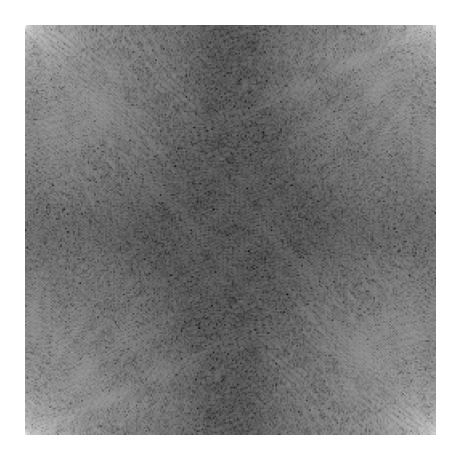

Fully sampled image:


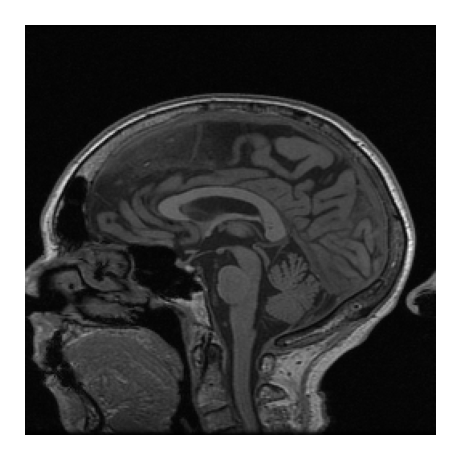

In [9]:
sampleKspace = np.load(kspace_files_train[file_index])

sr = 1 # Sampling-rate in the slice-encode direction
Nz = sampleKspace.shape[2] 
Nz_sampled = int(np.ceil(Nz*sr))
sampleKspace[:,:,Nz_sampled:,:] = 0

print("sampleKspace type: ",type(sampleKspace))
print("sampleKspace size: ",sampleKspace[:,:,1,:].size)

sampleKspace = sampleKspace[slice_index]
sampleKspace = sampleKspace[:,:,::2] + 1j*sampleKspace[:,:,1::2]

print("sampleKspace shape:",sampleKspace.shape)

# Displaying channels' k-spaces
print("k-space:") 
plt.figure(figsize = (10,10),dpi = 250)
gs1 = gridspec.GridSpec(4, 4)

for i in range(1):
    plt.subplot(gs1[i])
    plt.imshow(np.log(1+np.abs(sampleKspace[:,:,i])),cmap = "gray")
    plt.axis("off")
plt.show()

#implementing inverse fourier transform to k-space
sample_rec_train = np.fft.ifft2(sampleKspace,axes = (0,1))

print("Fully sampled image:") 
# Displaying channels' images
plt.figure(figsize = (10,10),dpi = 250)
gs1 = gridspec.GridSpec(4, 4)

for i in range(1):
    plt.subplot(gs1[i])
    plt.imshow(np.abs(sample_rec_train[:,:,i]),cmap = "gray")
    plt.axis("off")
plt.show()


Undersampling: 0.5
Mask type: bool


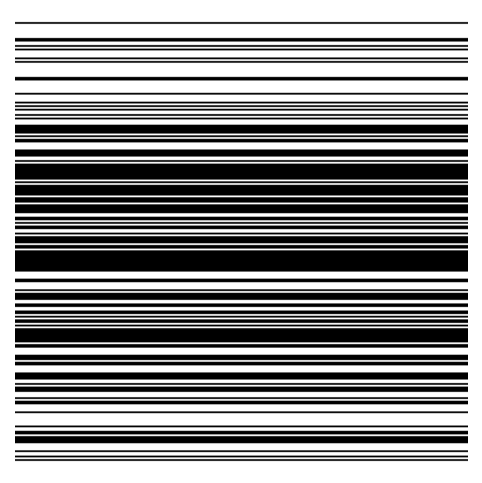

In [11]:
#cartesian mask
def normal_pdf(length, sensitivity):
    return np.exp(-sensitivity * (np.arange(length) - length / 2)**2)

def cartesian_mask(shape, acc, sample_n=10, centred=False):
  N, Nx, Ny = int(np.prod(shape[:-2])), shape[-2], shape[-1]
  pdf_x = normal_pdf(Nx, 0.5/(Nx/10.)**2)
  lmda = Nx/(2.*acc)
  n_lines = int(Nx / acc)

  pdf_x += lmda * 1./Nx

  if sample_n:
          pdf_x[Nx//2-sample_n//2:Nx//2+sample_n//2] = 0
          pdf_x /= np.sum(pdf_x)
          n_lines -= sample_n

  mask = np.zeros((N, Nx))
  for i in range(N):
    idx = np.random.choice(Nx, n_lines, False, pdf_x)
    mask[i, idx] = 1
      
  if sample_n:# sample data augmentation
    mask[:, Nx//2-sample_n//2:Nx//2+sample_n//2] = 1

  size = mask.itemsize
  mask = as_strided(mask, (N, Nx, Ny), (size * Nx, size, 0))

  mask = mask.reshape(shape)

  if not centred:
    mask = ifftshift(mask, axes=(-1, -2))

  return mask

imageShape = (256,256)
#creating the catesian mask
mask = cartesian_mask(imageShape, 2, sample_n=8)

#converting float mask to bool mask
var_sampling_mask = np.empty((256,256), dtype=bool)

for i in range(len(mask)):
  for j in range(len(mask[i])):
    if (mask[i][j] == 0):
      var_sampling_mask[i][j]=False
    else:
      var_sampling_mask[i][j]=True

print("Undersampling:" , 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
print("Mask type:",  var_sampling_mask.dtype)
plt.figure(dpi = 150)
plt.imshow(var_sampling_mask,cmap = "gray")
plt.axis("off")
plt.show()


Undersampling: 0.82293701171875
Mask type: bool


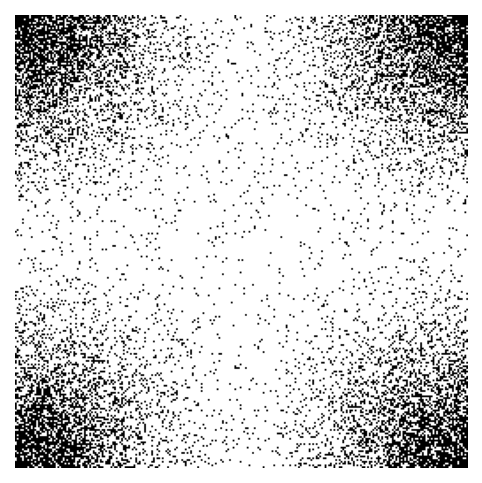

In [12]:
#UnderSampling With poisson masks
undersamplingRate = '20'
imshape = (256,256)
norm = np.sqrt(imshape[0]*imshape[1])
nChannels = 2 

var_sampling_mask = np.load("../Data/sampling_masks/sampling_mask_" + undersamplingRate + "perc.npy")

print("Undersampling:" , 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
print("Mask type:",  var_sampling_mask.dtype)
plt.figure(dpi = 150)
plt.imshow(var_sampling_mask,cmap = "gray")
plt.axis("off")
plt.show()

In [13]:
type(var_sampling_mask[0][1])
count = 0
for i in range(len(var_sampling_mask)):
  for j in range(len(var_sampling_mask[i])):
    if (var_sampling_mask[i][j] == 1):
      count = count + 1

print(count)

53932


Single Channel k-space


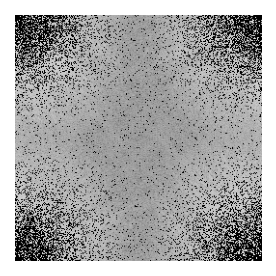

image


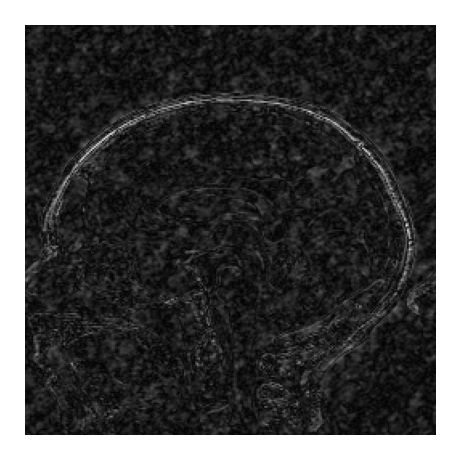

In [14]:
sampleKspaceMasked = sampleKspace.copy()
sampleKspaceMasked[~var_sampling_mask,:] = 0 # implementing the mask

# Displaying channels' k-spaces
print("Single Channel k-space")    

plt.figure(figsize = (10,10),dpi = 150)
gs1 = gridspec.GridSpec(4, 4)

for i in range(1):
    plt.subplot(gs1[i])
    plt.imshow(np.log(1+np.abs(sampleKspaceMasked[:,:,i])),cmap = "gray")
    plt.axis("off")
plt.show()


# Displaying channels' images
print("image")    
sampleTrainMasked = np.fft.ifft2(sampleKspaceMasked,axes = (0,1))

plt.figure(figsize = (10,10),dpi = 250)
gs1 = gridspec.GridSpec(4, 4)

for i in range(1):
    plt.subplot(gs1[i])
    plt.imshow(np.abs(sampleTrainMasked[:,:,i]),cmap = "gray")
    plt.axis("off")
plt.show()


In [15]:
#Load train data
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0]

# Load train data    
rec_train = np.zeros((ntrain,imshape[0],imshape[1],2))
kspace_train = np.zeros((ntrain,imshape[0],imshape[1],2))
aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = aux_kspace.shape[0]   
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     kspace_train[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[:,:,:,0]
     kspace_train[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[:,:,:,1]
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]

kspace_train[:,~var_sampling_mask,:] = 0 # undersample k-space

# save k-space and image domain stats
stats = np.zeros(4)
stats[0] = kspace_train.mean()
stats[1] = kspace_train.std()
aux = np.abs(rec_train[:,:,:,0] +1j*rec_train[:,:,:,1])
stats[2] = aux.mean()
stats[3] = aux.std()
np.save("../Data/stats_fs_unet_norm_" + undersamplingRate + ".npy",stats)

print("Number of training samples", rec_train.shape[0])
kspace_train = 0 # release memory

Number of training samples 680


In [16]:
#Load validation data
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    nval += np.load(kspace_files_val[ii]).shape[0]

kspace_val = np.zeros((nval,imshape[0],imshape[1],nChannels))
rec_val = np.zeros((nval,imshape[0],imshape[1],1))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = aux_kspace.shape[0]   
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    rec_val[aux_counter:aux_counter+aux,:,:,0] = \
    np.abs(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    aux_counter+=aux

# Undersampling kspace
kspace_val2 = kspace_val.copy()
kspace_val[:,~var_sampling_mask,:] = 0
kspace_val = (kspace_val-stats[0])/stats[1]

print("Number of samples", kspace_val.shape[0])
print("Kspace under stats", kspace_val.mean(),kspace_val.std())
print("Kspace full stats", kspace_val2.mean(),kspace_val2.std())
print("Rec stats", rec_val.mean(),rec_val.std())

Number of samples 1700
Kspace under stats 9.769820594695027e-05 0.9359746508142255
Kspace full stats 0.09448459411815589 1102.683960734151
Rec stats 4.026266893604261 4.571199197368037


In [17]:
#Initialize model
epochs = 3
batch_size= 16
mask = np.concatenate((var_sampling_mask[:,:,np.newaxis],var_sampling_mask[:,:,np.newaxis]),axis = -1) > 0
mask = mask.astype(np.float32)
model = fsnet.wnet(stats[0],stats[1],stats[2],stats[3],\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-7)
model.compile(loss = [fsnet.nrmse,fsnet.nrmse],optimizer=opt, loss_weights=[0.01, 0.99])

model_name = "../Models/wnet_" + undersamplingRate + ".hdf5"
model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 48) 2448        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 57648       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 57648       conv2d_1[0][0]                   
______________________________________________________________________________________________

(16, 256, 256, 1)


<Figure size 2500x2500 with 0 Axes>

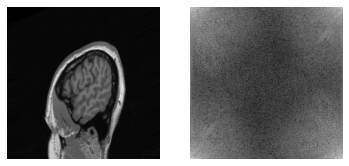

In [18]:
#Data augmentation
seed = 0
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest')

image_datagen1.fit(rec_train[:,:,:,0,np.newaxis], augment=True, seed=seed)
image_datagen2.fit(rec_train[:,:,:,1,np.newaxis], augment=True, seed=seed)

image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2,under_mask,stats):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        kspace_under = kspace2.copy()
        kspace_under[:,~var_sampling_mask,:] = 0
        kspace_under = (kspace_under-stats[0])/stats[1]
        rec = np.abs(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])[:,:,:,np.newaxis]
        yield(kspace_under, [kspace2,rec])

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2, var_sampling_mask,stats)

plt.figure(figsize = (10,10),dpi = 250)
gs1 = gridspec.GridSpec(4, 4)

# sample data augmentation
for ii in combined:
    print(ii[1][1].shape)
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[1][1][10,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(np.log(1+np.abs(ii[1][0][10,:,:,0] + 1j*ii[1][0][8,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.show()
    break


In [ ]:
print(type(combined))

<class 'generator'>


In [19]:
hist = model.fit(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping])


Epoch 1/3
42/42 [==============================] - 181s 3s/step - loss: 0.2691 - lambda_loss: 0.6837 - conv2d_43_loss: 0.2649 - val_loss: 0.2246 - val_lambda_loss: 0.6489 - val_conv2d_43_loss: 0.2203
Epoch 2/3
42/42 [==============================] - 83s 2s/step - loss: 0.1962 - lambda_loss: 0.6497 - conv2d_43_loss: 0.1916 - val_loss: 0.2090 - val_lambda_loss: 0.6415 - val_conv2d_43_loss: 0.2046
Epoch 3/3
42/42 [==============================] - 83s 2s/step - loss: 0.1774 - lambda_loss: 0.6502 - conv2d_43_loss: 0.1726 - val_loss: 0.2019 - val_lambda_loss: 0.6261 - val_conv2d_43_loss: 0.1976
